# Image Pre Processing


See image pre-processing decisions and notes

Preprocesses images loaded from the class balanced data set.
Uses previsouly extracted class_balanced_image_ids.csv file to ginf image ids that beling to balanced classes



    Image preprocessing issues and how addressed:

    1) Crop the image: No. Images are already focused on the lesion, are already centered and tightly cropped dermatoscopic images of the lesions. For simple feature extraction, additional cropping may remove useful context. Decision: no cropping.

    2) Center the image: images are already centered. Decision: No.

    3) Presence of hairs - can make mode mistake hairs as lesion boundaries or features. Decision: Hairs need to be used. Used ‘dull razor’ approach, as a preprocessing step; the approach detects hair using morphological operations and inpaints (fills) the detected regions. Use cv2 library (blackout filtering to find hair, threshold to detect hair, inpaint to remove hair)

    4) Handling scale markers on some images: if scale markers are present in a consistent region, that region can be cropped off. Scale markers do impact simple feature extraction e.g. for histogram bins, texture patterns. Decision: mask scale markers using  edge detector such as Canny.
    5) Resize all images to a fixed shape 224,224

    6) Gaussian blur as part of reimaging (Prof Hany's recommendation) to reduce noise? No, since blurr may reduce color variance and flatten histogrtam peaks for color histograms, may smoot edges and weaken gradients for Histogram of Oriented Gradience (HOG), remove sharp transitions for edge detection. 


    Summary: No crop, no center, remove hairs, mask scale, resize to 224 x 224. No Gaussian blur.


In [2]:
import numpy as np
import cv2 # OpenCV library
import matplotlib.pyplot as plt
from PIL import Image
import urllib

from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine
from skimage import exposure

In [3]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow_datasets as tfds

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

import keras
import keras_tuner as kt

from keras import layers, models
from keras.optimizers import Adam
from tensorflow.keras import layers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.metrics import confusion_matrix

import joblib

# shap
#import shap

import openpyxl

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
from sklearn.decomposition import PCA

import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


random.seed(42)


In [4]:
def whoAmI(img):
    """
    Prints dtype, min, max, mean, height, and width of an image.
    """
    print(f"dtype     : {img.dtype}")
    print(f"min       : {np.min(img):.4f}")
    print(f"max       : {np.max(img):.4f}")
    print(f"mean      : {np.mean(img):.4f}")
    print(f"shape     : {img.shape}")
    if img.ndim == 2:
        print(f"height    : {img.shape[0]}")
        print(f"width     : {img.shape[1]}")
    elif img.ndim == 3:
        print(f"height    : {img.shape[0]}")
        print(f"width     : {img.shape[1]}")
        print(f"channels  : {img.shape[2]}")

#VS - II helpful functions

# summarizes a data frame in a printer friendly way
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Column Name': df.columns,
        'Data Type': df.dtypes.values,
        'Null Count': df.isnull().sum().values,
        'Non-Null Count': df.notnull().sum().values,
        'Unique Count': df.nunique().values
    })
    return summary

def plot_training_history(history):
    """
    Plots training and validation loss & accuracy from a Keras history object.

    Parameters:
    - history: Keras history object from model.fit()
    """

    epochs = range(1, len(history.history['loss']) + 1)

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']


    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='-')
    ax[0].plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, train_acc, label='Training Accuracy', color='blue', linestyle='-')
    ax[1].plot(epochs, val_acc, label='Validation Accuracy', color='red', linestyle='--')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [5]:
DATA_DIR = '/Users/vishalsaxena/Documents/BERKMIDS2024ROOT/09MIDSCourses/MIDS281CompVision/281_Final_Project/281_FP_Factory/dataset/skin-cancer-mnist-ham10000/'
DATA_DIR_IMAGES = DATA_DIR + '/HAM10000_images/'

BALANCED_CLASS_CSV_FILE = '/Users/vishalsaxena/Documents/BERKMIDS2024ROOT/09MIDSCourses/MIDS281CompVision/281_Final_Project/281_FP_Factory/class_balanced_image_ids.csv'


In [14]:
def load_raw_image_files_and_class_labels(image_folder_path=DATA_DIR_IMAGES, csv_file_path=BALANCED_CLASS_CSV_FILE):
    """
    Using image id from the balanced class csv file, loads jpg images into a raw array.
    Matching class labels are loaded into another array.
    3 arrays returned: array of image ids, array of their matching raw images, array of their matching class labels
    
    """
    try:
        df = pd.read_csv(csv_file_path)
        print(f"Successfully loaded CSV file: {csv_file_path}")
        print(f"Total entries in CSV: {len(df)}")
    except FileNotFoundError:
        print(f"Error: CSV file not found at {csv_file_path}")
        return np.array([], dtype=object), np.array([])
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        return np.array([], dtype=object), np.array([])

    image_ids = []
    raw_images = []
    raw_labels = []

    print("Starting to load images...")
    for index, row in df.iterrows():
        image_id = row['index']
        class_label = row['dx']

        image_filename = f"{image_id}.jpg"
        image_full_path = os.path.join(image_folder_path, image_filename)

        try:
            img = Image.open(image_full_path)
            image_ids.append(image_id)
            raw_images.append(img)
            raw_labels.append(class_label)

        except FileNotFoundError:
            print(f"Warning: Image file not found for {image_id} at {image_full_path}. Skipping.")
        except Exception as e:
            print(f"Error loading image {image_id} from {image_full_path}: {e}. Skipping.")

    print(f"Finished loading {len(raw_images)} images.")

    print("\n--- Loading Summary ---")
    print(f"Lenght of raw_images list (list of image arrays): {len(raw_images)}")
    print(f"Length of raw_labels: {len(raw_labels)}")
    print(f"First 5 labels: {raw_labels[:5]}")

    return image_ids, raw_images, raw_labels

# Hair removal
def remove_hairs(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, thresh = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    result = cv2.inpaint(img, thresh, 1, cv2.INPAINT_TELEA)
    return result


# Canny to mask scale

def mask_scale_markers(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h > 500 and (w/h > 5 or h/w > 5):
            img[y:y+h, x:x+w] = 0  # mask with black
    return img


In [15]:
raw_image_ids, raw_images, raw_labels = load_raw_image_files_and_class_labels()

Successfully loaded CSV file: /Users/vishalsaxena/Documents/BERKMIDS2024ROOT/09MIDSCourses/MIDS281CompVision/281_Final_Project/281_FP_Factory/class_balanced_image_ids.csv
Total entries in CSV: 8659
Starting to load images...
Finished loading 8659 images.

--- Loading Summary ---
Lenght of raw_images list (list of image arrays): 8659
Length of raw_labels: 8659
First 5 labels: ['nv', 'vasc', 'nv', 'bkl', 'mel']


In [11]:
type(raw_images[0])

PIL.JpegImagePlugin.JpegImageFile

In [12]:
# Remove hairs
hair_removed_images = [remove_hairs(np.array(img)) for img in raw_images]
hair_removed_images = np.array(hair_removed_images)

In [16]:
len(hair_removed_images)

8659

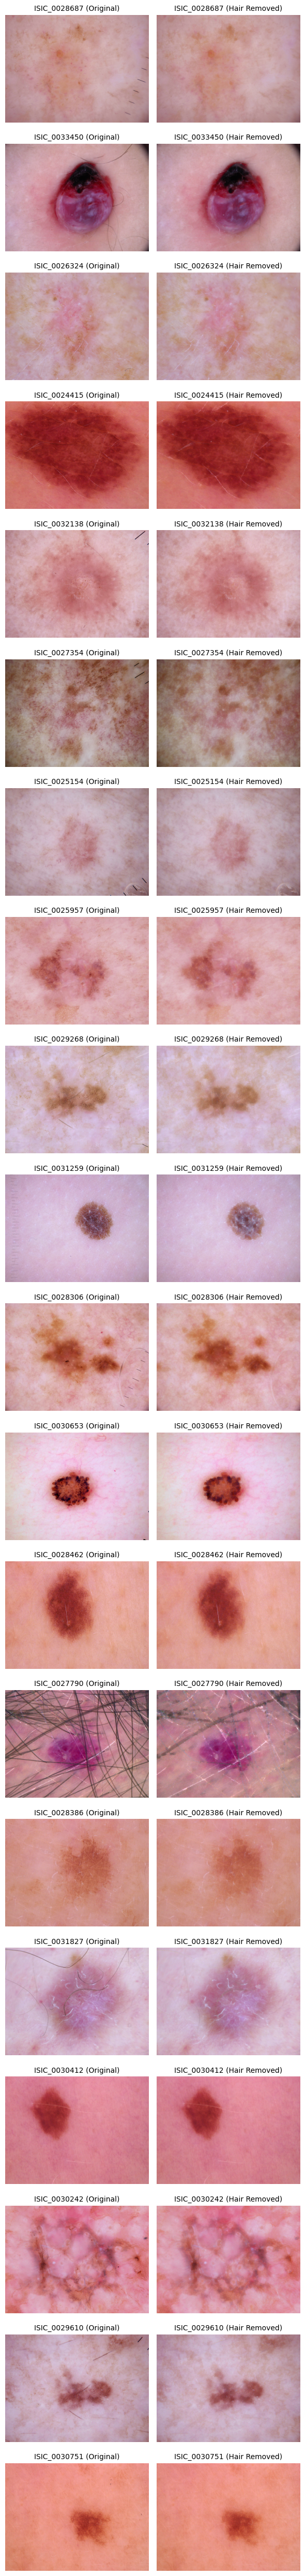

In [18]:
#Plot 20 randomly selected images and their hair removed versions


# Sample 20 random indices
random.seed(42)
sample_indices = random.sample(range(len(raw_images)), 20)

# Set up grid: 20 rows (one per image pair), 2 columns (original, hair-removed)
fig, axes = plt.subplots(20, 2, figsize=(6, 50))  # taller layout

for row, idx in enumerate(sample_indices):
    # Get images and ID
    orig_img = np.array(raw_images[idx])
    clean_img = np.array(hair_removed_images[idx])
    image_id = raw_image_ids[idx]

    # Column 0: Original
    axes[row, 0].imshow(orig_img)
    axes[row, 0].set_title(f"{image_id} (Original)", fontsize=10)
    axes[row, 0].axis("off")

    # Column 1: Hair Removed
    axes[row, 1].imshow(clean_img)
    axes[row, 1].set_title(f"{image_id} (Hair Removed)", fontsize=10)
    axes[row, 1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


In [30]:
# Now apply canny to mask scale (remove ruler markings)
scale_removed_images = [mask_scale_markers(np.array(img)) for img in hair_removed_images]
scale_removed_images = np.array(scale_removed_images)

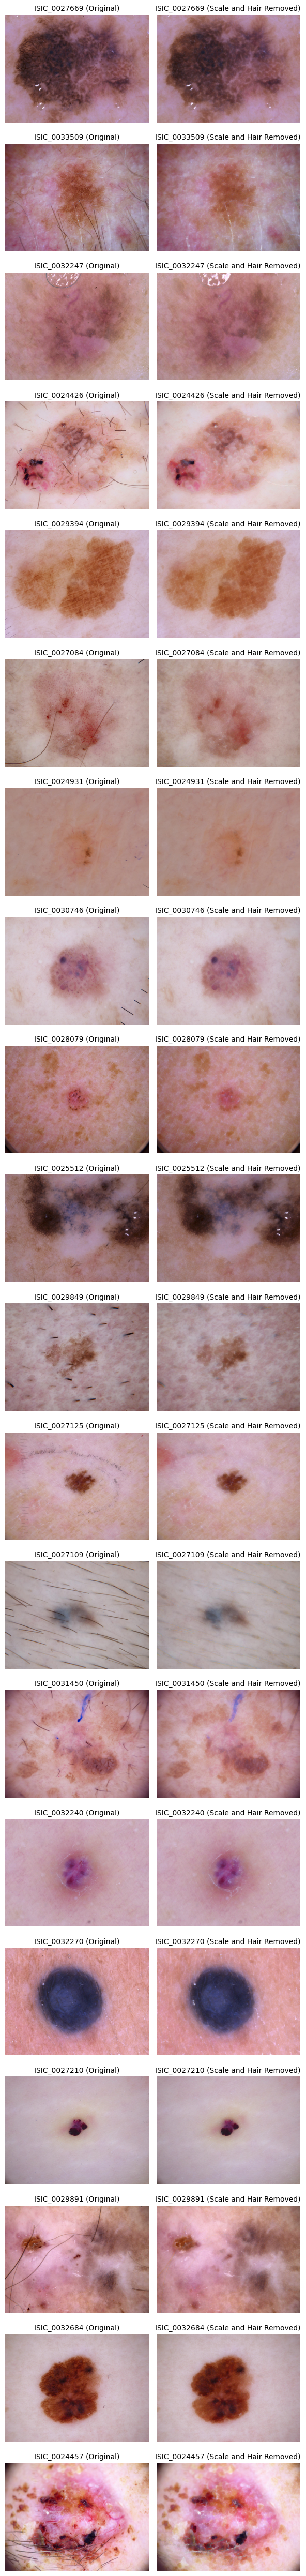

In [31]:
#Plot 20 randomly selected images and their hair and scale removed versions

# Sample 20 random indices
sample_indices = random.sample(range(len(raw_images)), 20)

# Set up grid: 20 rows (one per image pair), 2 columns (original, scaled_removed_images)
fig, axes = plt.subplots(20, 2, figsize=(6, 50))  # taller layout

for row, idx in enumerate(sample_indices):
    # Get images and ID
    orig_img = np.array(raw_images[idx])
    clean_img = np.array(scale_removed_images[idx])
    image_id = raw_image_ids[idx]

    # Column 0: Original
    axes[row, 0].imshow(orig_img)
    axes[row, 0].set_title(f"{image_id} (Original)", fontsize=10)
    axes[row, 0].axis("off")

    # Column 1: Hair Removed
    axes[row, 1].imshow(clean_img)
    axes[row, 1].set_title(f"{image_id} (Scale and Hair Removed)", fontsize=10)
    axes[row, 1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

In [32]:
scale_removed_images.shape

(8659, 450, 600, 3)

In [33]:
#resize to 224 x 224

resized_scale_removed_images = [cv2.resize(np.array(img), (224,224)) for img in scale_removed_images]
resized_scale_removed_images = np.array(resized_scale_removed_images)

In [34]:
resized_scale_removed_images.shape

(8659, 224, 224, 3)

In [36]:
raw_labels = np.array(raw_labels)
raw_labels.shape

(8659,)

# MILESTONE: The images and to use for resized scale removed and simple feature extraction 
    resized_scale_removed_images,
    raw_labels

In [ ]:
# HOG
